# SN Like candidates in the last 4 days
### Ken Smith
Get supernova candidates ingested into Lasair within the last 14 days.  This notebook will use the Lasair client code, except for acquisiton of the user token.

Demonstrates usage of:
* /query/
* /objects/

### Python (3 only) requirements - pip install
lasair, requests

In [1]:
!pip install lasair

DEPRECATION: Loading egg at /Users/roywilliams/Library/Python/3.11/lib/python/site-packages/pyglet-2.0.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [2]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
from lasair import LasairError, lasair_client as lasair
import requests

### Make an SQL query
Note that the database is not very old - a few months.  (It's very much a prototype system, which may be destroyed and rebuilt at a moment's notice.)  Hence there will be no data older than 2021 in this system.

In [3]:
# Get the objectId, coordinates, mjdmin, mjdmax, min r mag, most recent r mag
# sherlock designation, and a crude star / galaxy score (based on dist from PS1
# object and star/galaxy score of closest PS1 source)
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

# Join objects and sherlock_classifications
tables = 'objects,sherlock_classifications'

# The object should be less than 4 days old, classified by sherlock as SN or
# UNCLEAR, number of detections is 3 or more, latest g-mag brighter than 20
# (for ePESSTO+ followup), has 2 or more positive flux detections and has a name
# with a 21 designation.
conditions = """
objects.jdmin > JDNOW() - 14.0
AND sherlock_classifications.classification NOT IN ("VS" , "AGN", "CV", "BS")
AND objects.ncand >= 3
AND objects.rmag < 20
AND objects.ncandgp > 1
AND objects.objectId like 'ZTF23%'
ORDER BY score, objectId DESC
"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 10)
except LasairError as e:
    print(e)


In [4]:
for row in results:
    print(row['objectId'],
          "%.5f" % row['ramean'],
          "%.5f" % row['decmean'],
          "%.5f" % row['mjdmin'],
          "%.5f" % row['mjdmax'],
          "%.2f" % row['magrmin'],
          "%.2f" % row['rmag'],
          row['classification'],
          row['score'])


ZTF23abpxqlo 73.77937 -26.94293 60252.38788 60258.37661 19.19 19.24 SN Not_PS1_star
ZTF23abpwkhp 102.48228 64.46407 60252.40755 60258.44793 19.98 19.98 SN Not_PS1_star
ZTF23abptujg 114.63518 25.32021 60253.44553 60257.49704 19.49 19.49 SN Not_PS1_star
ZTF23abptnaj 155.33767 22.50761 60257.48447 60257.51828 18.23 18.27 NT Not_PS1_star
ZTF23abprycr 50.57572 18.02082 60253.24113 60257.38022 19.83 19.83 SN Not_PS1_star
ZTF23abppvoz 349.97714 11.97997 60252.16582 60257.18770 19.79 19.79 SN Not_PS1_star
ZTF23abpkxwp 299.75748 21.44743 60255.11110 60258.15097 18.44 19.08 SN Not_PS1_star
ZTF23abpkqrx 183.41469 -5.96498 60254.54013 60255.54471 18.95 18.95 NT Not_PS1_star
ZTF23abpjefb 161.41076 71.10691 60252.52691 60258.45411 19.81 19.82 SN Not_PS1_star
ZTF23abpiigx 100.01498 38.11060 60252.42370 60258.43399 19.90 19.90 SN Not_PS1_star


### Grab the lightcurves using the objects API

https://lasair-ztf.lsst.ac.uk/object/ZTF23abpxqlo has no TNS info in Lasair yet
https://lasair-ztf.lsst.ac.uk/object/ZTF23abpwkhp has no TNS info in Lasair yet
https://lasair-ztf.lsst.ac.uk/object/ZTF23abptujg AT2023xec
https://lasair-ztf.lsst.ac.uk/object/ZTF23abptnaj has no TNS info in Lasair yet
https://lasair-ztf.lsst.ac.uk/object/ZTF23abprycr has no TNS info in Lasair yet
https://lasair-ztf.lsst.ac.uk/object/ZTF23abppvoz AT2023xfo
https://lasair-ztf.lsst.ac.uk/object/ZTF23abpkxwp has no TNS info in Lasair yet
https://lasair-ztf.lsst.ac.uk/object/ZTF23abpkqrx AT2023xfc
https://lasair-ztf.lsst.ac.uk/object/ZTF23abpjefb AT2023wuu
https://lasair-ztf.lsst.ac.uk/object/ZTF23abpiigx has no TNS info in Lasair yet


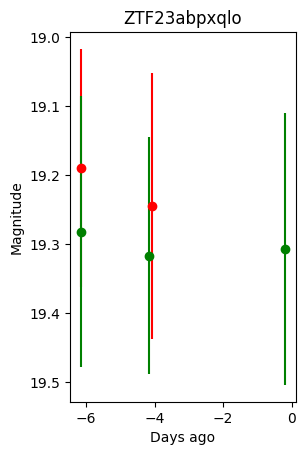

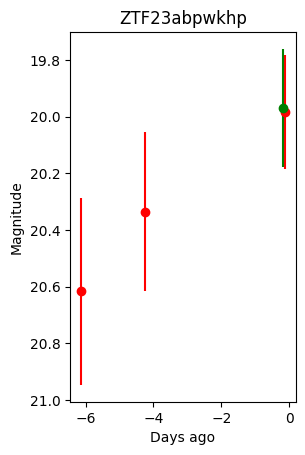

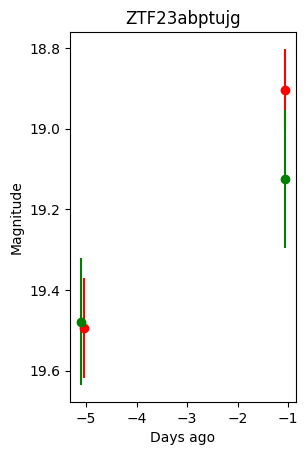

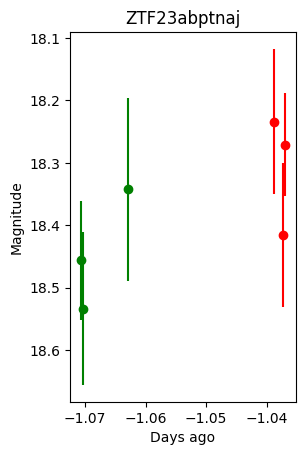

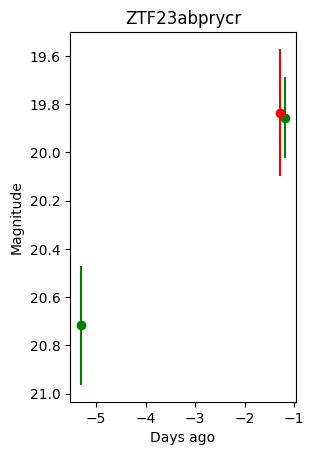

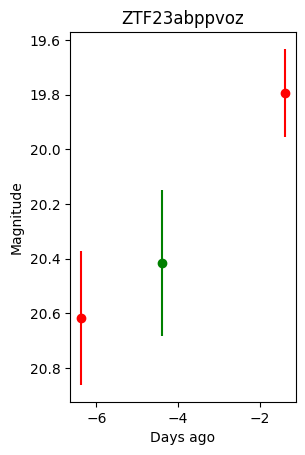

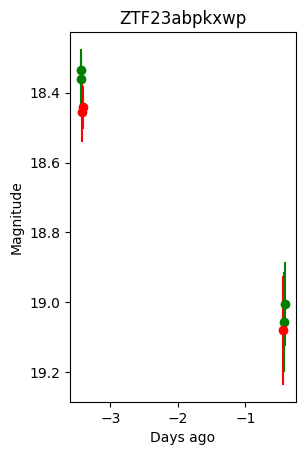

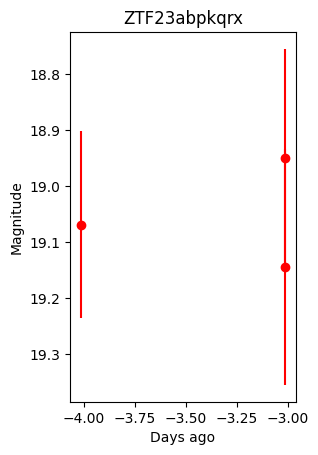

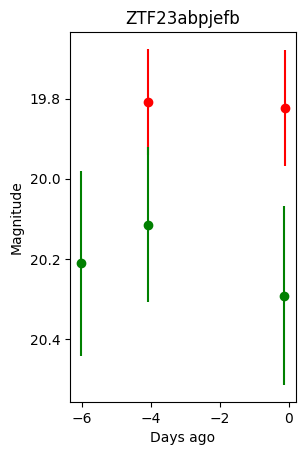

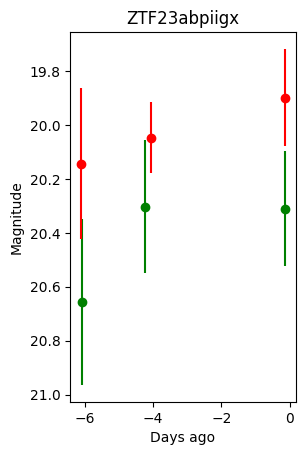

In [5]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r'}

now = Time.now().jd

for obj in response:
        try:
            print ('https://lasair-ztf.lsst.ac.uk/object/%s %s%s' % (obj['objectId'], obj['TNS']['tns_prefix'], obj['TNS']['tns_name']))
        except KeyError as e:
            print ('https://lasair-ztf.lsst.ac.uk/object/%s %s' % (obj['objectId'], "has no TNS info in Lasair yet"))
        plt.figure()
        plt.subplot(121)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
